# Read in netcdfs, and plot results

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration

In [54]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [3]:
!ls /g/data/w48/kb6999/20CR_temp_members/R_anom_Glob_TMP*.nc

/g/data/w48/kb6999/20CR_temp_members/R_anom_Glob_TMP01.nc
/g/data/w48/kb6999/20CR_temp_members/R_anom_Glob_TMP02.nc
/g/data/w48/kb6999/20CR_temp_members/R_anom_Glob_TMP03.nc
/g/data/w48/kb6999/20CR_temp_members/R_anom_Glob_TMP04.nc
/g/data/w48/kb6999/20CR_temp_members/R_anom_Glob_TMP05.nc
/g/data/w48/kb6999/20CR_temp_members/R_anom_Glob_TMP06.nc
/g/data/w48/kb6999/20CR_temp_members/R_anom_Glob_TMP07.nc
/g/data/w48/kb6999/20CR_temp_members/R_anom_Glob_TMP08.nc
/g/data/w48/kb6999/20CR_temp_members/R_anom_Glob_TMP09.nc
/g/data/w48/kb6999/20CR_temp_members/R_anom_Glob_TMP10.nc
/g/data/w48/kb6999/20CR_temp_members/R_anom_Glob_TMP11.nc
/g/data/w48/kb6999/20CR_temp_members/R_anom_Glob_TMP12.nc
/g/data/w48/kb6999/20CR_temp_members/R_anom_Glob_TMP13.nc
/g/data/w48/kb6999/20CR_temp_members/R_anom_Glob_TMP14.nc
/g/data/w48/kb6999/20CR_temp_members/R_anom_Glob_TMP15.nc


In [7]:
# Create a list with all the strings identifying your members
# use a combination of range and zfill to get the leading zeros.
member_list = [str(x).zfill(2) for x in range(1,81)]

In [47]:
member_list = member_list[slice(0,14)]

## need to change name of TMP folder to 20CR_TMP_members

In [58]:
funcR.read_reanalysis('PRATE', member_list[slice(0,1)])
# funcR.read_reanalysis('TMP', member_list[slice(0,1)])

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512, member: 1, time: 1992)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2015-12-31
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
    month    (time) int64 dask.array<chunksize=(1992,), meta=np.ndarray>
  * member   (member) <U2 '01'
Data variables:
    PRATE    (member, time, lat, lon) float32 dask.array<chunksize=(1, 1992, 100, 100), meta=np.ndarray>

In [ ]:
# combine precipitation and temperature into one dataset
reanal = xr.Dataset({'tmp': ds_tmp.TMP, 'pr': ds_pr.PRATE})
# change the pr units
models['pr'] = models.pr*86400
models

In [12]:
reanalysis_TMP_dir = f'/g/data/w48/kb6999/20CR_TMP_members/'

## try to read in the netcdfs of the anomaly files i calculated using the member dimesnion 

In [15]:
# load temp data
member_ds_t = {}
for m in member_list:
    member_ds_t[m] = xr.open_mfdataset(f'{reanalysis_dir}R_anom_Glob_TMP{m}.nc', parallel=True)
    member_ds_t[m] = member_ds_t[m].chunk(chunks={'time':-1, 'lat':100, 'lon':100})

In [17]:
# concatenate the data into an xarray with the new member dimension
# the dask line reduces the size of the chunks and hopefully allows tmp to be plotted without the kernel dying
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_tmps = xr.concat(member_ds_t.values(), dim='member')
ds_tmps.coords['member'] = member_list

In [20]:
# rename temp variable 
reanal = xr.Dataset({'tmp': ds_tmps.TMP})
reanal

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512, member: 14, time: 1992)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2015-12-31
  * lon      (lon) float32 0.0 0.703 1.406 2.109 ... 357.1 357.8 358.5 359.2
  * lat      (lat) float32 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * member   (member) <U2 '01' '02' '03' '04' '05' ... '10' '11' '12' '13' '14'
Data variables:
    tmp      (member, time, lat, lon) float32 dask.array<chunksize=(1, 1992, 100, 100), meta=np.ndarray>

## area weighting and landmask

In [21]:
# area weighting 
reanal_w = reanal*np.cos(reanal.lat*(np.pi/180))
reanal_w

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512, member: 14, time: 1992)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2015-12-31
  * lon      (lon) float32 0.0 0.703 1.406 2.109 ... 357.1 357.8 358.5 359.2
  * lat      (lat) float32 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * member   (member) <U2 '01' '02' '03' '04' '05' ... '10' '11' '12' '13' '14'
Data variables:
    tmp      (member, time, lat, lon) float32 dask.array<chunksize=(1, 1992, 100, 100), meta=np.ndarray>

In [30]:
monthly_anom_glob = reanal_w

In [31]:
# import landmask dataset 
landfrac_ds = xr.open_dataset('/g/data/w48/kb6999/20CR_data_netcdfs/land_20CR.nc')
landmask = landfrac_ds

In [39]:
# Select out SH and NH anomalies 
monthly_anom_SH = monthly_anom_glob.sel(lat=slice(0,-90)) 
monthly_anom_NH = monthly_anom_glob.sel(lat=slice(90,0)) 
# select out the Australian and E Australian anomalies 
monthly_anom_Aus = monthly_anom_glob.sel(lat=slice(-10,-50), lon=slice(110,160)).where(landmask.LAND==1, drop=True)
monthly_anom_EA = monthly_anom_glob.sel(lat=slice(-10,-50), lon=slice(140,155)).where(landmask.LAND==1, drop=True)

## means and percentiles

In [40]:
# take lat lon mean
llm_Glob = monthly_anom_glob.mean(dim=['lat','lon'])
llm_SH = monthly_anom_SH.mean(dim=['lat','lon'])
llm_NH = monthly_anom_NH.mean(dim=['lat','lon'])
llm_Aus = monthly_anom_Aus.mean(dim=['lat','lon'])
llm_EA = monthly_anom_EA.mean(dim=['lat','lon'])

In [42]:
llm_SH

<xarray.Dataset>
Dimensions:  (member: 14, time: 1992)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2015-12-31
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * member   (member) <U2 '01' '02' '03' '04' '05' ... '10' '11' '12' '13' '14'
Data variables:
    tmp      (member, time) float32 dask.array<chunksize=(1, 1992), meta=np.ndarray>

In [43]:
# calculate the percentiles and then take the mean along the model dimension for monthly anomalies
p10_mon_Glob = llm_Glob.chunk({'member': -1}).quantile(0.1, dim=['member'])
p10_mon_SH = llm_SH.chunk({'member': -1}).quantile(0.1, dim=['member'])
p10_mon_Aus = llm_Aus.chunk({'member': -1}).quantile(0.1, dim=['member'])
p10_mon_EA = llm_EA.chunk({'member': -1}).quantile(0.1, dim=['member'])
# calculate the percentiles and then take the mean along the model dimension for monthly anomalies
p90_mon_Glob = llm_Glob.chunk({'member': -1}).quantile(0.9, dim=['member'])
p90_mon_SH = llm_SH.chunk({'member': -1}).quantile(0.9, dim=['member'])
p90_mon_Aus = llm_Aus.chunk({'member': -1}).quantile(0.9, dim=['member'])
p90_mon_EA = llm_EA.chunk({'member': -1}).quantile(0.9, dim=['member'])

In [44]:
# Take the multi-member mean for each region
mmm_mon_Glob = llm_Glob.mean(dim='member')
mmm_mon_SH = llm_SH.mean(dim='member')
mmm_mon_Aus = llm_Aus.mean(dim='member')
mmm_mon_EA = llm_EA.mean(dim='member')

In [45]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

[########################################] | 100% Completed | 18.7s
[########################################] | 100% Completed | 13.1s
[########################################] | 100% Completed | 10.8s
[########################################] | 100% Completed |  7.8s
[########################################] | 100% Completed |  7.8s
[########################################] | 100% Completed |  8.1s
[########################################] | 100% Completed |  7.6s
[########################################] | 100% Completed |  7.6s
[########################################] | 100% Completed |  6.8s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.2s


[Text(0, 0.5, 'Temperature anomaly [°C]'), Text(0.5, 1.0, 'Eastern Australia')]

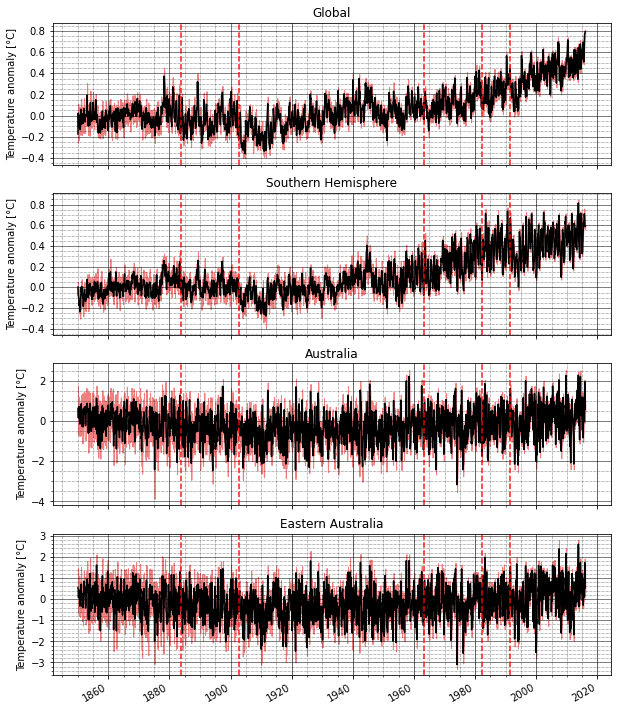

In [46]:
# Monthly temperature anomalies stacked
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(mmm_mon_Glob.tmp, p10_mon_Glob.tmp, p90_mon_Glob.tmp, ax = axes[0], color='lightcoral')
    fplot.timeseries_graph(mmm_mon_SH.tmp, p10_mon_SH.tmp, p90_mon_SH.tmp, ax = axes[1], color='lightcoral')
    fplot.timeseries_graph(mmm_mon_Aus.tmp, p10_mon_Aus.tmp, p90_mon_Aus.tmp, ax = axes[2], color='lightcoral')
    fplot.timeseries_graph(mmm_mon_EA.tmp, p10_mon_EA.tmp, p90_mon_EA.tmp, ax = axes[3], color='lightcoral')

axes[0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[1].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[3].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Eastern Australia')

#fig.suptitle('Time series of temperature anomalies', size=16)

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

# plt.savefig('R_timeseries_mon_tmp_stacked.png', dpi=300, bbox_inches='tight')